In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
from pprint import pprint
import csv
import random
import requests, re, json
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

In [8]:
def datareader(club_name, season):
    # Read the CSV files
    transfers_df = pd.read_csv('transfers.csv')
    games_df = pd.read_csv('games.csv')
    lineups_df = pd.read_csv('game_lineups.csv')
    
    # Filter transfers for the given club and season
    club_transfers = transfers_df[(transfers_df['to_club_name'] == club_name) & (transfers_df['transfer_season'] == season)].copy()
    
    if club_transfers.empty:
        print(f"No transfers found for {club_name} in {season} season.")
        return pd.DataFrame()
    
    # Get the club_id
    club_id = club_transfers['to_club_id'].iloc[0]
    
    # Filter games for the club, season, and specific competition and round
    season_year = int(season.split('/')[0]) + 2000
    club_games = games_df[(games_df['home_club_id'] == club_id) | (games_df['away_club_id'] == club_id)].copy()
    club_games = club_games[(club_games['season'] == season_year) & (club_games['competition_id'] == 'GB1') & (club_games['round'] == '38. Matchday')]
    
    # Get the club's position
    if not club_games.empty:
        if club_games['home_club_id'].iloc[0] == club_id:
            position = club_games['home_club_position'].iloc[0]
        else:
            position = club_games['away_club_position'].iloc[0]
    else:
        print(f"No matching game found for {club_name} in {season} season.")
        position = np.nan
    
    # Calculate starting percentage
    lineups_for_club = lineups_df[lineups_df['club_id'] == club_id].copy()
    player_appearances = lineups_for_club.groupby('player_id').agg(total_appearances=('type', 'count'),starting_appearances=
                                                                   ('type', lambda x: (x == 'starting_lineup').sum()))
    player_appearances['starting_percentage'] = (player_appearances['starting_appearances'] / player_appearances['total_appearances'] * 100).round(2)
    
    # Create the final dataframe
    result_df = club_transfers[['player_id', 'transfer_fee', 'market_value_in_eur']].copy()
    result_df.loc[:, 'club_id'] = club_id
    result_df.loc[:, 'club_position'] = position
    
    # Merge with starting percentages
    result_df = result_df.merge(
        player_appearances[['starting_percentage']], 
        left_on='player_id', 
        right_index=True, 
        how='left'
    )
    
    # Fill NaN values with 0 for starting_percentage
    result_df.loc[:, 'starting_percentage'] = result_df['starting_percentage'].fillna(0)
    
    return result_df

In [10]:
# Example usage
club_name = "Wolves"
season = "18/19"
df = datareader(club_name, season)
print(df)

       player_id  transfer_fee  market_value_in_eur  club_id  club_position  \
41999     233124           0.0            1000000.0      543            7.0   
42270     361254           0.0            3000000.0      543            7.0   
42987     175446    21000000.0           12000000.0      543            7.0   
43699     180843           0.0             500000.0      543            7.0   
44724     168157           0.0           17000000.0      543            7.0   
44746     525247     4750000.0                  NaN      543            7.0   
44757     204103    20000000.0            8000000.0      543            7.0   
45038     175446           0.0           12000000.0      543            7.0   
45083      29364     5600000.0           10000000.0      543            7.0   
45604      45026    18000000.0           16000000.0      543            7.0   
45743     142310    12000000.0            5000000.0      543            7.0   
45839     206040           0.0           15000000.0 

In [30]:
def create_transfer_spending_bargraph(club_names, seasons):
    transfers_df = pd.read_csv('transfers.csv')
    
    # Set up the figure
    plt.figure(figsize=(12, 8))
    
    # Width of each bar
    bar_width = 0.15
    
    # Set up positions for bars
    x = np.arange(len(seasons))
    
    for i, club in enumerate(club_names):
        avg_spent_per_transfer = []
        
        for season in seasons:
            # Filter transfers for the given club and season
            club_transfers = transfers_df[(transfers_df['to_club_name'] == club) & 
                                       (transfers_df['transfer_season'] == season)]
            
            if not club_transfers.empty:
                total_value = club_transfers['market_value_in_eur'].sum() + club_transfers['transfer_fee'].sum()
                num_transfers = len(club_transfers)
                avg_value = total_value / num_transfers
                avg_spent_per_transfer.append(avg_value)
            else:
                avg_spent_per_transfer.append(0)
        
        # Plot bars for this club
        plt.bar(x + i * bar_width, avg_spent_per_transfer, 
                bar_width, label=club)
        
        # Add value labels on top of bars
        for idx, value in enumerate(avg_spent_per_transfer):
            if value > 0:
                plt.text(x[idx] + i * bar_width, value, 
                        f'{value/1000000:.1f}M', 
                        ha='center', va='bottom')
    
    # Customize the plot
    plt.xlabel('Season')
    plt.ylabel('Average Spending per Transfer (in €)')
    plt.title('Average Spending Per Transfer by Season')
    plt.xticks(x + bar_width/2, seasons)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

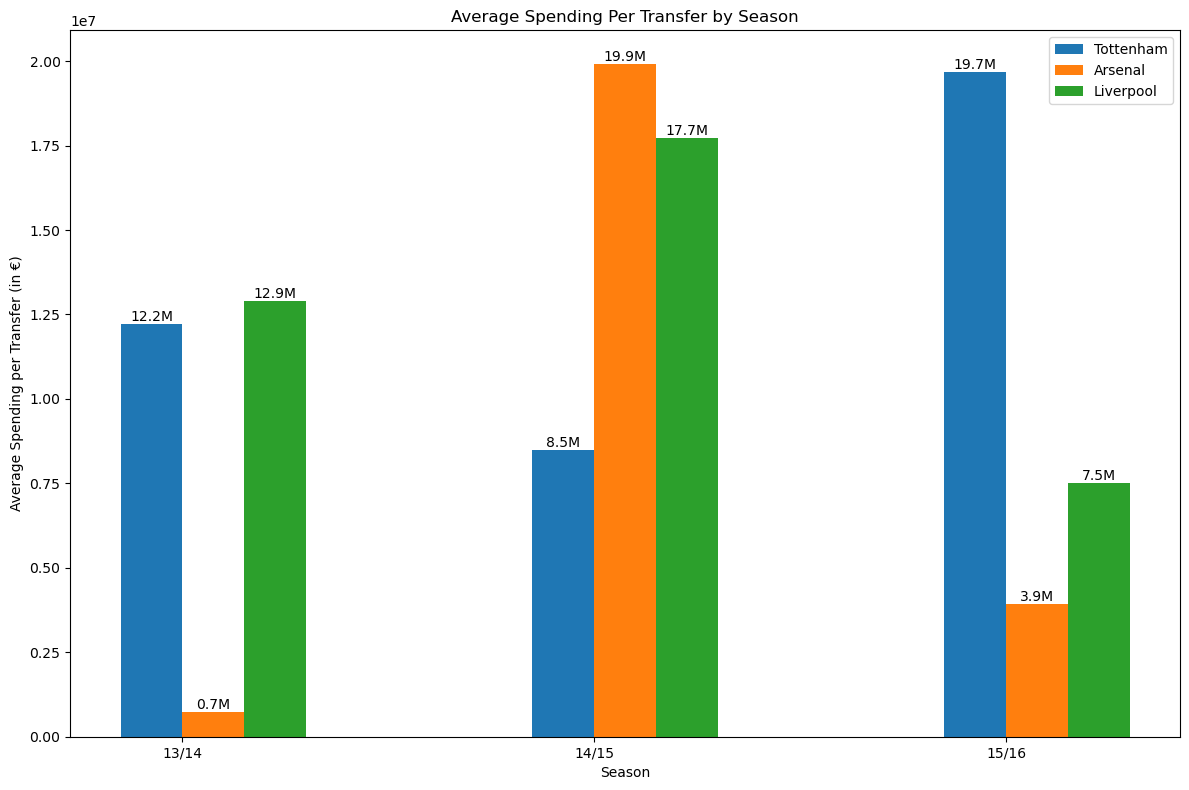

In [32]:
# Example usage
club_names = ["Tottenham", "Arsenal", "Liverpool"]
seasons = ["13/14", "14/15", "15/16"]

create_transfer_spending_bargraph(club_names, seasons)

In [ ]:
            17/18      18/19
Club A:      5th         8th
Club B:     10th         1st

In [38]:
def create_position_table(club_names, seasons):
    # Create an empty dictionary to store positions
    positions = {season: {} for season in seasons}
    
    # Fill the dictionary with positions for each club and season
    for club in club_names:
        for season in seasons:
            # Get data using abc() function
            df = datareader(club, season)
            
            if not df.empty:
                # Get the club position from the data
                position = df['club_position'].iloc[0]
                positions[season][club] = position
            else:
                positions[season][club] = 'N/A'
    
    # Convert dictionary to DataFrame
    position_table = pd.DataFrame(positions)
    
    # Format the table
    position_table = position_table.fillna('N/A')
    
    return position_table

In [42]:
# Example usage
club_names = ["Brighton", "Arsenal"]
seasons = ["16/17", "17/18", "18/19"]

table = create_position_table(club_names, seasons)
print(table)

No matching game found for Brighton in 16/17 season.
         16/17  17/18  18/19
Brighton   N/A   15.0   17.0
Arsenal    5.0    6.0    5.0
